<a href="https://colab.research.google.com/github/Shopping-Yuan/ML2021HW/blob/Shopping_vscode_branch/HW6/HW06_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Hw6
###Part 0 : setting & install package
###Part 1 : data cleaning
###Part 2 : build model
###Part 3 : training and validation
###Part 4 : inference

###setting

In [ ]:
setting = {
# information of the path of dataset
"documents" : {
    "workspace_dir" : "/content/drive/MyDrive/HW6_data",
    "log_doc_path" : "/log",
    "ckpt_file_path" : "/model",
    "model_temp_save_path" : "/temporary_model",
    "out_doc_path" : "/out",
},
"dataset" : {
},
"dataloader" : {
    "batch_size" : 64,
    "num_workers" : 2,
    "shuffle" : True,
},
# model setting
"model" : {
    "sample_random_range" : 100,
    "generator_in_dimension" : 100
},
# setting in training and validation process ,
# including optimization setting.
"training_hparas" : {
    "total_epoch" : 50, # 50
    "generator_epoch" : 5, # 5
    "validation_epoch" : 5, # 5
    "temp_save_epoch" : 1,
    "wgan_clip_value" : 0.01,
    },
"generator_optimizer" : {
    "lr" : 1e-4,
    "betas" : (0.5, 0.999)
    },
"discriminator_optimizer" : {
    "lr" : 1e-4,
    "betas" : (0.5, 0.999)
    },
}

###install package

In [ ]:
!pip install qqdm
!pip install torchinfo

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.6 MB/s eta 0:00:00
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6468 sha256=89ccad52eeeb6d2819d0c56a9e14ee940d8aafb65f73e770c55fd3d00159ab26
  Stored in directory: /root/.cache/pip/wheels/40/1a/56/5dccdea123a172661eb65c8c29fde4567dbda2b72b5fc5893a
Successfully built qqdm


In [ ]:
# step 1 : download dataset from drive to google colab
# original dataset is in "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U"

workspace_dir = "/content/drive/MyDrive/HW6_data"
rawdata_file_path = workspace_dir + "/crypko_data.zip"
unzip_path = "/content/unzip_image/"

# mount drive
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path)

# step 2 : unzip dataset
import zipfile
with zipfile.ZipFile(rawdata_file_path, 'r') as zip_f:
    zip_f.extractall(unzip_path)

Mounted at /content/drive


In [ ]:
import random

import torch
import numpy as np


def seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:

import torch
import os
import glob
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
class CrypkoDataset(Dataset):
  def __init__(self):
    self.imgs = glob.glob(os.path.join(unzip_path,"faces","*"))

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    img = torchvision.io.read_image(self.imgs[index])
    return self.crypko_transform(img)
    # return img

  def crypko_transform(self,img):
    compose = [
          v2.ToPILImage(),
          v2.Resize((64, 64)),
          v2.ToTensor(),
          v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
          ]
    transform =  v2.Compose(compose)
    return transform(img)

def get_dataloader(dataset,batch_size,shuffle,num_workers):
  return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


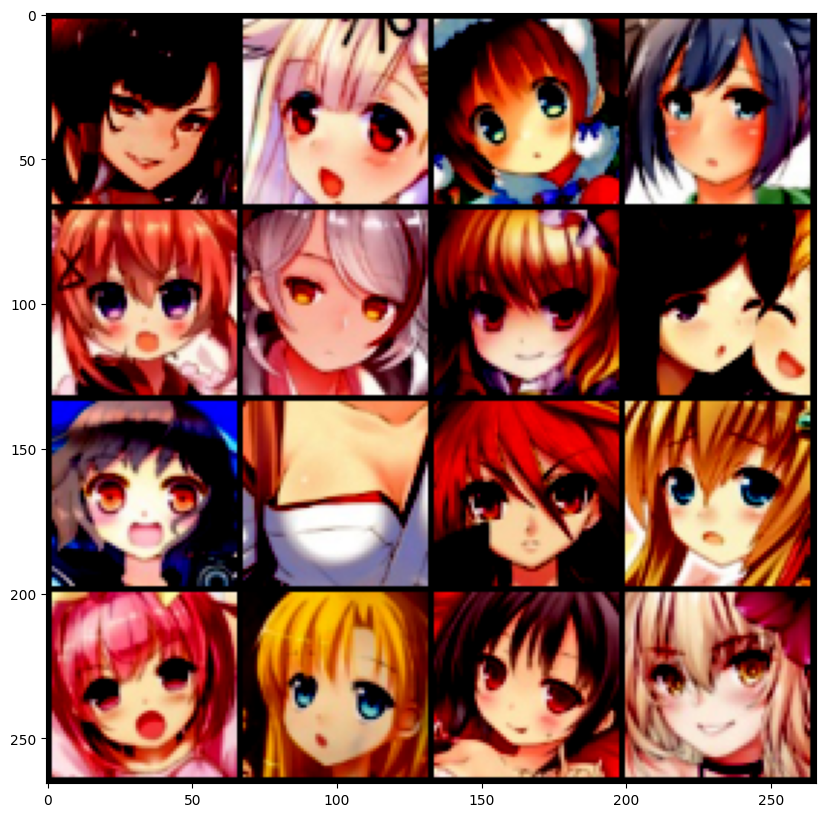

In [ ]:
dataset = CrypkoDataset()
images = [dataset[i] for i in range(16)]
# print(images[0][0][0][0],type(images[0][0][0][0].item()))
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
out = grid_img.permute(1, 2, 0)
plt.imshow(out)
plt.show()

In [ ]:
import torch.nn as nn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
class Print(nn.Module):
    def __init__(self):
      super().__init__()
    def forward(self,x):
      print(x.shape)
      return x
class Generator(nn.Module):
    def __init__(self, in_dim, dim=64):
      super().__init__()
      self.indim = in_dim
      self.dim = dim
      def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                          padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())
      self.l1 = nn.Sequential(
            nn.Linear(self.indim, self.dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(self.dim * 8 * 4 * 4),
            nn.ReLU())
      self.l2_5 = nn.Sequential(
            dconv_bn_relu(self.dim * 8, self.dim * 4),
            dconv_bn_relu(self.dim * 4, self.dim * 2),
            dconv_bn_relu(self.dim * 2, self.dim),
            nn.ConvTranspose2d(self.dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh()
        )
      self.apply(weights_init)
    def forward(self,x):
      y = self.l1(x)
      batch_size = y.size(0)
      dconv_dim = self.dim*8
      y = y.view(batch_size,dconv_dim,4,4)
      y = self.l2_5(y)
      return y

class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )

        """ Medium: Remove the last sigmoid layer for WGAN. """
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2),
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid(),
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

In [ ]:
from torchinfo import summary
model_G = Generator(100)
print(summary(model_G,(32,100)))
input = torch.rand(32,100)
print(model_G(input).shape)
# model_D = Discriminator(3)
# print(summary(model_D,(32,3,64,64)))
# input = torch.rand(32,3,64,64)
# print(model_D(input).shape)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 64, 64]           --
├─Sequential: 1-1                        [32, 8192]                --
│    └─Linear: 2-1                       [32, 8192]                819,200
│    └─BatchNorm1d: 2-2                  [32, 8192]                16,384
│    └─ReLU: 2-3                         [32, 8192]                --
├─Sequential: 1-2                        [32, 3, 64, 64]           --
│    └─Sequential: 2-4                   [32, 256, 8, 8]           --
│    │    └─ConvTranspose2d: 3-1         [32, 256, 8, 8]           3,276,800
│    │    └─BatchNorm2d: 3-2             [32, 256, 8, 8]           512
│    │    └─ReLU: 3-3                    [32, 256, 8, 8]           --
│    └─Sequential: 2-5                   [32, 128, 16, 16]         --
│    │    └─ConvTranspose2d: 3-4         [32, 128, 16, 16]         819,200
│    │    └─BatchNorm2d: 3-5             [32, 128, 16, 16]     

In [ ]:
import os
from qqdm.notebook import qqdm
def train_val(documents,dataset,dataloader,model,training_hparas,
        generator_optimizer,discriminator_optimizer):
  #set seeds
  seeds(2021)

  #doc paths
  paths = list(documents.values())
  workspace_dir, log_doc_path, ckpt_file_path, model_temp_save_path, out_doc_path = paths
  print(workspace_dir)
  for path in paths[1:]:
    full_path = workspace_dir+path
    os.makedirs(full_path,exist_ok=True)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # Dataset
  dataset = CrypkoDataset()
  # DataLoader
  dataloader = get_dataloader(dataset, **dataloader)

  # test sample
  sample_random_range, generator_in_dimension = list(model.values())
  sample = torch.rand(sample_random_range, generator_in_dimension)
  sample = sample.to(device)

  # Model
  G = Generator(in_dim = generator_in_dimension).to(device)
  D = Discriminator(3).to(device)
  G.train()
  D.train()

  # Loss
  criterion = nn.BCELoss()

  """ Medium: Use RMSprop for WGAN. """
  # Optimizer
  opt_D = torch.optim.Adam(D.parameters(), **discriminator_optimizer)
  opt_G = torch.optim.Adam(G.parameters(), **generator_optimizer)
  # opt_D = torch.optim.RMSprop(D.parameters(), lr = list(discriminator_optimizer.values()[0])
  # opt_G = torch.optim.RMSprop(G.parameters(), lr = list(generator_optimizer.values()[0])

  # training_hparas
  total_epoch, generator_epoch, validation_epoch, temp_save_epoch, wgan_clip_value = \
  list(training_hparas.values())


  steps = 0
  for e, epoch in enumerate(range(total_epoch)):
      progress_bar = qqdm(dataloader)
      for i, data in enumerate(progress_bar):
          imgs = data
          imgs = imgs.to(device)

          batch_size = imgs.size(0)

          # ============================================
          #  Train D
          # ============================================
          train_sample = torch.rand(batch_size, generator_in_dimension)
          train_sample = train_sample.to(device)
          r_imgs = imgs.to(device)
          f_imgs = G(train_sample)

          """ Medium: Use WGAN Loss. """
          # Label
          r_label = torch.ones((batch_size)).to(device)
          f_label = torch.zeros((batch_size)).to(device)
          # Model forwarding
          r_logit = D(r_imgs.detach())
          f_logit = D(f_imgs.detach())

          # Compute the loss for the discriminator.
          # r_loss = criterion(r_logit, r_label)
          # f_loss = criterion(f_logit, f_label)
          # loss_D = (r_loss + f_loss) / 2

          # WGAN Loss
          loss_D = -(torch.mean(D(r_imgs)) + torch.mean(D(f_imgs)))


          # Model backwarding
          D.zero_grad()
          loss_D.backward()

          # Update the discriminator.
          opt_D.step()

          """ Medium: Clip weights of discriminator. """
          for p in D.parameters():
             p.data.clamp_(-wgan_clip_value, wgan_clip_value)

          # ============================================
          #  Train G
          # ============================================
          if steps % generator_epoch == 0:
              # Generate some fake images.
              train_sample = torch.rand(batch_size, generator_in_dimension)
              train_sample = train_sample.to(device)
              f_imgs = G(train_sample)

              # Model forwarding
              f_logit = D(f_imgs)

              """ Medium: Use WGAN Loss"""
              # Compute the loss for the generator.
              # loss_G = criterion(f_logit, r_label)
              # WGAN Loss
              loss_G = -torch.mean(D(f_imgs))

              # Model backwarding
              G.zero_grad()
              loss_G.backward()

              # Update the generator.
              opt_G.step()

          steps += 1

          # Set the info of the progress bar
          #   Note that the value of the GAN loss is not directly related to
          #   the quality of the generated images.
          progress_bar.set_infos({
              'Loss_D': round(loss_D.item(), 4),
              'Loss_G': round(loss_G.item(), 4),
              'Epoch': e+1,
              'Step': steps,
          })

      G.eval()
      f_imgs_sample = (G(sample).data + 1) / 2.0
      print(G(sample).data[0:5])
      filename = workspace_dir + log_doc_path + f'Epoch_{epoch+1:03d}.jpg'
      torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
      print(f' | Save some samples to {filename}.')

      # Show generated images in the jupyter notebook.
      grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
      plt.figure(figsize=(10,10))
      plt.imshow(grid_img.permute(1, 2, 0))
      plt.show()
      G.train()

      if (e+1) % 5 == 0 or e == 0:
          # Save the checkpoints.
          torch.save(G.state_dict(), workspace_dir + ckpt_file_path + 'G.pth')
          torch.save(D.state_dict(), workspace_dir + ckpt_file_path + 'D.pth')

In [ ]:
train_val(**setting)

/content/drive/MyDrive/HW6_data


 Iters     Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step                                   
 1/1115  00:00:07<02:23:06  0.13it/s  1.2131  1.3277    1     1                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])


KeyboardInterrupt: 

In [ ]:
import torch
def inference(documents,model):
  # documents
    paths = list(documents.values())
    workspace_dir, log_doc_path, ckpt_file_path, model_temp_save_path, out_doc_path = paths

  # Model
  sample_random_range, generator_in_dimension = list(model.values())
  G = Generator(in_dim = generator_in_dimension)
  G.load_state_dict(torch.load(os.path.join(ckpt_file_path, 'G.pth')))
  G.eval()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  G.to(device)
  # Generate 1000 images and make a grid to save them.
  n_output = 1000
  sample = torch.rand(sample_random_range, generator_in_dimension).to(device)
  imgs_sample = (G(sample).data + 1) / 2.0

  # log and save image
  log_dir = workspace_dir+log_doc_path
  filename = os.path.join(log_doc_path, 'result.jpg')
  torchvision.utils.save_image(imgs_sample, filename, nrow=10)

  # Show 32 of the images.
  grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
  plt.figure(figsize=(10,10))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()

  # Save the generated images.
  os.makedirs('output', exist_ok=True)
  for i in range(1000):
      torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')


In [ ]:
inference(**setting)

In [ ]:
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..